In [1]:
# -------------------------------------------------------------------------------------
# Third party imports
# -------------------------------------------------------------------------------------
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import glob 

import astropy
from astropy.io import fits
from astropy.time import Time
from astropy.units import allclose as quantity_allclose
from astropy import units as u
from astropy import constants as c
from astropy.coordinates import SkyCoord
from astropy.coordinates.builtin_frames import FK5, ICRS, GCRS, GeocentricMeanEcliptic, BarycentricMeanEcliptic, HeliocentricMeanEcliptic, GeocentricTrueEcliptic, BarycentricTrueEcliptic, HeliocentricTrueEcliptic, HeliocentricEclipticIAU76
from astropy.constants import R_sun, R_earth
from astropy.nddata import CCDData

from matplotlib.colors import LogNorm

from IPython.display import display, Markdown, clear_output

import inspect
import importlib
import warnings
warnings.filterwarnings('ignore')

# Plot setup
matplotlib.rc('font', size=22, family='normal', weight='bold')
plt.rcParams['figure.figsize'] = [10, 4]
np.printoptions(suppress=True)

In [58]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
import glob
filenames=sorted(glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183??????*.fits'))[0::15][:20]
print(f"{len(filenames)} files")
print(' '.join(filenames))

20 files
/home/mikea/.shifty_data/tess/5/1/4/tess2018319225938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018320062938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018320135938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018320212938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018321045938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018321122938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018321195938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018322032938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018322105938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018322185938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018323022938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty_data/tess/5/1/4/tess2018323095938-s0005-1-4-0125-s_ffic.fits /home/mikea/.shifty

<IPython.core.display.Javascript object>


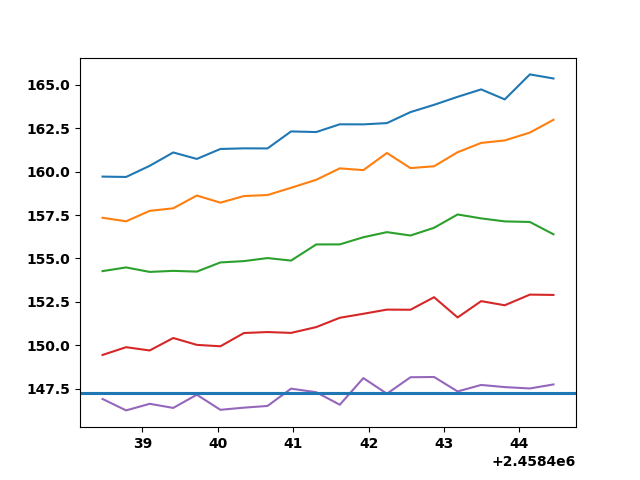

<IPython.core.display.Javascript object>


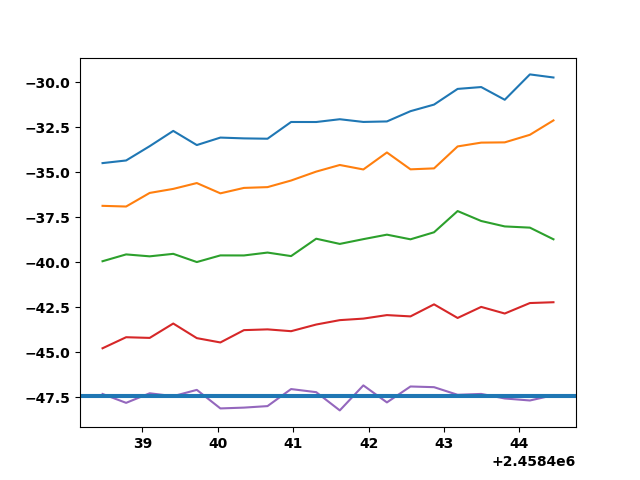

Combining images using median stacking.
Saving to file Tess_20images-mean_stack_median.fits
Done!
Combining images using mean stacking
Saving to file Tess_20images-mean_stack_mean.fits
Done!


In [59]:
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False)
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
plt.figure()
plt.plot(times, [d[204,199] for d in D.image_data.data])
plt.plot(times, [d[406,368] for d in D.image_data.data])
plt.plot(times, [d[604,591] for d in D.image_data.data])
plt.plot(times, [d[803,796] for d in D.image_data.data])
plt.plot(times, [d[1019,1011] for d in D.image_data.data])
plt.axhline(np.mean([d[1019,1011] for d in D.image_data.data]))
plt.axhline(np.median([d[1019,1011] for d in D.image_data.data]))
for d in D.image_data.data:
    d -= np.mean(d)
plt.figure()
plt.plot(times, [d[204,199] for d in D.image_data.data])
plt.plot(times, [d[406,368] for d in D.image_data.data])
plt.plot(times, [d[604,591] for d in D.image_data.data])
plt.plot(times, [d[803,796] for d in D.image_data.data])
plt.plot(times, [d[1019,1011] for d in D.image_data.data])
plt.axhline(np.mean([d[1019,1011] for d in D.image_data.data]))
plt.axhline(np.median([d[1019,1011] for d in D.image_data.data]))
D.stack(shifted=False, median_combine=True)
D.save_stack(f'Tess_{len(times)}images-mean_stack_median.fits')
D.stack(shifted=False, median_combine=False)
D.save_stack(f'Tess_{len(times)}images-mean_stack_mean.fits')

<IPython.core.display.Javascript object>


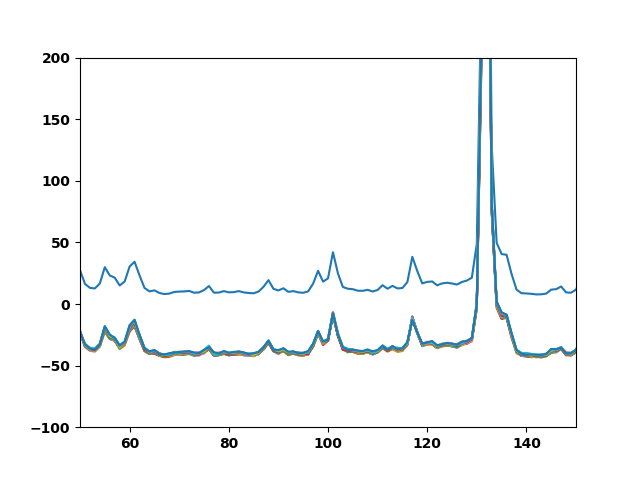

<IPython.core.display.Javascript object>


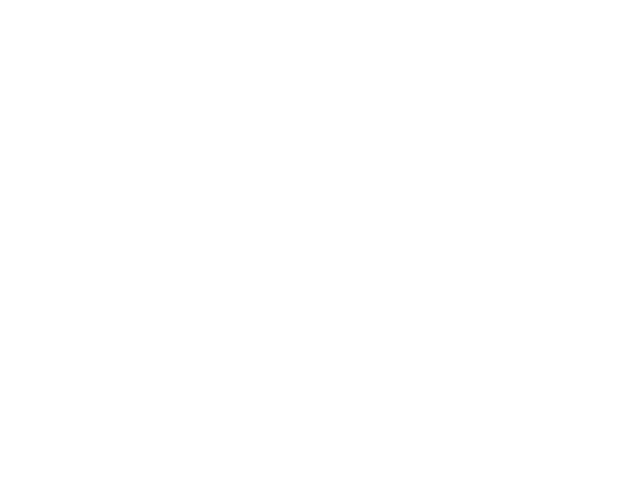

<IPython.core.display.Javascript object>


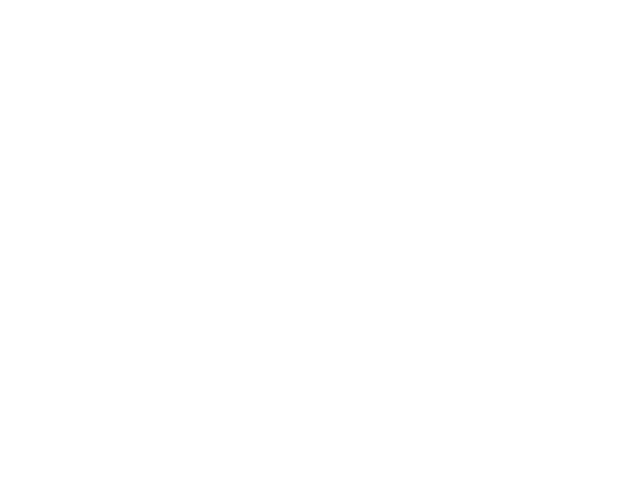

In [60]:
plt.figure()
plt.plot(D.stacked_data.data[1019]+50)
for d in D.image_data.data:
    plt.plot(d[1019])
plt.axis([50,150,-100,200])
plt.figure()

<IPython.core.display.Javascript object>


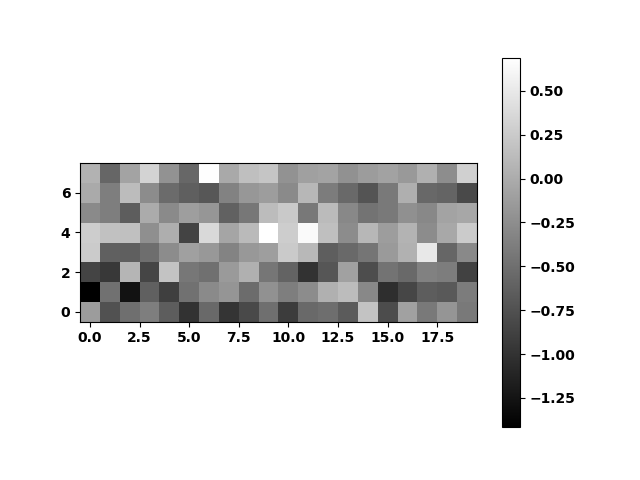

Combining images using median stacking.
Saving to file Tess_20images-mean_stack_median_cutout.fits
Done!
Combining images using mean stacking
Saving to file Tess_20images-mean_stack_mean_cutout.fits
Done!


<IPython.core.display.Javascript object>


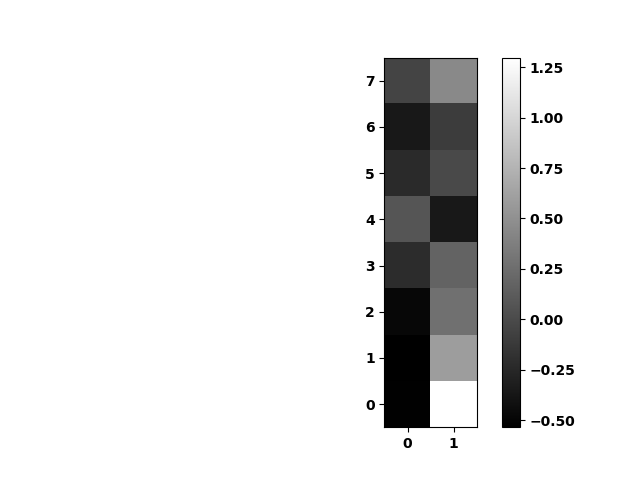

<IPython.core.display.Javascript object>


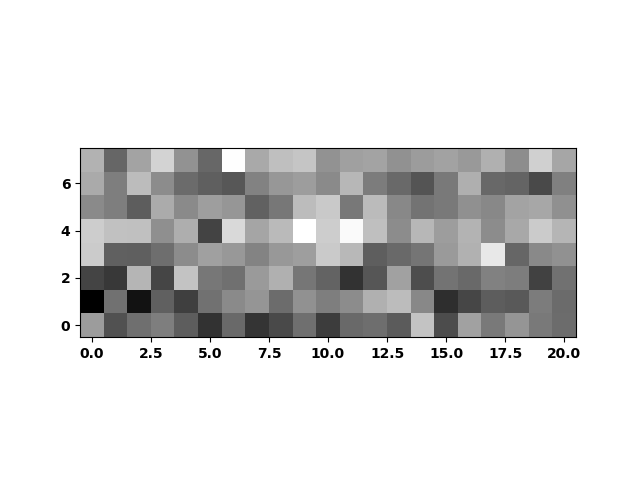

In [74]:
%matplotlib notebook
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False)
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
#plt.imshow(D.image_data.data[0], origin='lower', cmap='gray',norm=LogNorm())
#cbar = plt.colorbar()
new_data = D.image_data.data[:, 985:1015, 1060:1100]
new_data = D.image_data.data[:, 995:1003, 1079:1081]
D.image_data.data = new_data
for d in D.image_data.data:
    d -= np.mean(d)
plt.figure()
plt.imshow(np.array([d[:,0] for d in D.image_data.data]).T[:,:20], origin='lower', cmap='gray')
cbar = plt.colorbar()
D.stack(shifted=False, median_combine=True)
D.save_stack(f'Tess_{len(times)}images-mean_stack_median_cutout.fits')
D.stack(shifted=False, median_combine=False)
D.save_stack(f'Tess_{len(times)}images-mean_stack_mean_cutout.fits')
plt.figure()
plt.imshow(D.stacked_data.data, origin='lower', cmap='gray')
bar = plt.colorbar()
plt.figure()
a=[d[:,0] for d in D.image_data.data]
a.append(D.stacked_data.data[:,0])
plt.imshow(np.array(a).T, origin='lower', cmap='gray')

# plt.figure()
for d in D.image_data.data:
    plt.plot(d[:,0]-np.mean(d[:,0]))
plt.plot(D.stacked_data.data[:,0]-np.mean(D.stacked_data.data[:,0]), lw=5)
plt.figure()
for d in D.image_data.data:
    plt.plot(d[:,-1]-np.mean(d[:,-1]))
plt.plot(D.stacked_data.data[:,-1]-np.mean(D.stacked_data.data[:,-1]), lw=5)

# Initial conditions and expected values:

In [ ]:
# Local imports
sys.path.append(os.path.join(os.path.split(os.getcwd())[0], 'shifty'))
import imagehandler
importlib.reload(imagehandler)
import glob
xxx=[]
ppp=[]
for iii in np.arange(0,25):
    filenames=sorted(glob.glob('/home/mikea/.shifty_data/tess/5/1/4/tess20183??????*.fits'))[iii::25]
    '''
    Get times and shifts (as calculated by Horizons)
    '''
    importlib.reload(imagehandler)
    D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                               MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=False)
    shifts = D._calculate_shifts_from_known(object_name='2012 TF315', obs_code='500@-95')
    times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
    print(len(times))
    D.integer_shift(shifts, padmean=True)
    D.stack(shifted=False, median_combine=True)
    D.save_stack(f'Tess_{len(times)}images_stack{iii}.fits')
    unshifted_stack = D.stacked_data.data
    
    for d in D.image_data.data:
        d -= unshifted_stack  
    '''
    Shift+stack using the known (from Horizons + WCS) shifts.
    '''
    shiftss=shifts.copy()
    shifts[:,1]=shiftss[:,1]
    shifts[:,0]=shiftss[:,0]
    D.integer_shift(shifts, padmean=True)
    D.stack(shifted=True, median_combine=True)
    D.save_stack(f'shift+stack_Tess_2012TF315_jpl{iii}.fits')
    xy0 = np.array([848, 1023]) - np.min(shifts,0).astype(int)
    print(xy0)
    xxx.append(xy0)
    xym = xy0 - 100
    xyp = xy0 + 100
    counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
    peak_count = np.max(counts_above_background[80:120,80:120])
    noise = np.std(counts_above_background)
    sigma = peak_count / noise
    print(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)')
    ppp.append([peak_count, noise, sigma])

for i, x in enumerate(xxx):
    print(x)
    print(ppp[i])

# 2009 DE69

In [ ]:
'''
Get times and shifts (as calculated by Horizons)
'''
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=True)
shifts = D._calculate_shifts_from_known(object_name='2009 DE69', obs_code='500@-95')
times = np.array([dh['SHIFTY_MJD_MID'] for dh in D.image_data.header]) + 2400000.5
print(len(times))
print(shifts.astype(int))
D.integer_shift(shifts, padmean=True)
D.stack(shifted=False, median_combine=False)
D.save_stack(f'Tess_{len(times)}images_stack.fits')
unshifted_stack = D.stacked_data.data

In [ ]:
len(times)

In [ ]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess', verbose=True)
shifts = D._calculate_shifts_from_known(object_name='2009 DE69', obs_code='500@-95')
for d in D.image_data.data:
    d -= unshifted_stack  
print(1)
'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
shiftss=shifts.copy()
print(2)
shifts[:,1]=shiftss[:,1]
shifts[:,0]=shiftss[:,0]
print(3)
D.integer_shift(shifts, padmean=True)
print(4)
D.stack(shifted=True, median_combine=True)
print(5)
D.save_stack(f'shift+stack_Tess_2009DE69_jpl{iii}.fits')
print(6)
#D.save_shifted('shift_Tess_2009DE69_jpl')
print(7)
xy0 = np.array([1342, 877]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
print(8)
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
print(9)
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

# Dorothea

In [ ]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess')
shifts = D._calculate_shifts_from_known(object_name='Dorothea', obs_code='500@-95')
for d in D.image_data.data:
    d -= unshifted_stack
'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
shiftss=shifts.copy()
shifts[:,1]=shiftss[:,1]
shifts[:,0]=shiftss[:,0]
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=True)
D.save_stack('shift+stack_Tess_Dorothea_jpl.fits')
D.save_shifted('shift_Tess_Dorothea_jpl')
xy0 = np.array([1342, 877]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

# Sedna

In [ ]:
importlib.reload(imagehandler)
D=imagehandler.DataHandler(filenames, extno=1, EXPTIME='EXPOSURE', EXPUNIT='d', MAGZERO=18.,
                           MJD_START='BJDREFI+TSTART+-2400000.5', GAIN='GAINA', FILTER='-Tess')
shifts = D._calculate_shifts_from_known(object_name='Sedna', obs_code='500@-95')
for d in D.image_data.data:
    d -= unshifted_stack
    d[unshifted_stack > np.median(unshifted_stack)+5] = 0
'''
Shift+stack using the known (from Horizons + WCS) shifts.
'''
shiftss=shifts.copy()
shifts[:,1]=shiftss[:,1]
shifts[:,0]=shiftss[:,0]
D.integer_shift(shifts, padmean=True)
D.stack(shifted=True, median_combine=False)
D.save_stack('shift+stack_Tess_Sedna_jpl.fits')
D.save_shifted('shift_Tess_Sedna_jpl')
xy0 = np.array([1543, 1103]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

In [ ]:
xy0 = np.array([1103, 1543]) - np.min(shifts,0).astype(int)
print(xy0)
xym = xy0 - 100
xyp = xy0 + 100
plt.imshow((D.stacked_data.data-np.nanmin(D.stacked_data.data))[xym[0]:xyp[0],xym[1]:xyp[1]], origin='lower', cmap='gray',norm=LogNorm())
cbar = plt.colorbar()
counts_above_background = (D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]-np.nanmedian(D.stacked_data.data[xym[0]:xyp[0],xym[1]:xyp[1]]))
peak_count = np.max(counts_above_background[80:120,80:120])
noise = np.std(counts_above_background)
sigma = peak_count / noise
display(Markdown(fr'Peak count $\pm$ noise = {peak_count:4.1f} $\pm$ {noise:4.1f} ({sigma:4.1f}$\sigma$)'))

In [ ]:
shifts.astype(int)

In [ ]:
'''
Get the EXPECTED thetas from the JPL Horizons ephemerides.
'''
from astroquery.jplhorizons import Horizons
# Query for reference time:
horizons_query0 = Horizons(id='sedna', location='568', epochs=time0, id_type='smallbody')
horizons_ephem0 = horizons_query0.ephemerides(extra_precision=False)
# Query for whole array of times:
horizons_query = Horizons(id='sedna', location='568', epochs=times, id_type='smallbody')
horizons_ephem = horizons_query.ephemerides(extra_precision=False)

latlon_expected = np.array(eq_to_ec(np.radians(horizons_ephem['RA']), np.radians(horizons_ephem['DEC']))).T
expected_thetas = np.array(ec_to_proj(*latlon_expected.T, *latlon0)).T
expected_thetas_asec = np.degrees(expected_thetas) * 3600
print(expected_thetas_asec)

In [ ]:
horizons_ephem['RA'][0],horizons_ephem['DEC'][0]

### Now with thetas/shifts calculated from ABG